## **Advanced Analyitcs and Applications**

Desciption 

#### Team: 
- Robin Reiners
- Saied Farham Nia

##### **Table of Contents**

0. [Notebook Setup](#Notebook-Set-Up-and-Imports)
1. [Introduction](#Introduction)
2. [Data Loading and Cleaning](#Data-Loading-and-Cleaning)
3. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis)
4. [Methodology](#Methodology)
5. [Results and Analysis](#Results-and-Analysis)
6. [Discussion and Conclusion](#Discussion-and-Conclusion)
7. [References](#References)

##### **Notebook Set Up and Imports**

In [1]:
%%html
<style>
.dataframe th {
    font-family: "JetBrainsMono Nerd Font";
}
.dataframe td {
    font-family: "JetBrainsMono Nerd Font";
}
</style>

**Imports**

In [2]:
import importlib
import os
import pickle
import subprocess
import sys
import yaml
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
sys.path.append(str(Path.cwd().parent))
from src.utils.notebook_setup import load_files, setup_notebook

style_manager = setup_notebook()

if str(Path().resolve()).split("/")[-1] == "AAA":
    print("already set repo root")
else:
    notebooks_dir = Path().resolve()
    repo_root = notebooks_dir.parent
    results_dir = repo_root / "data" / "results"
    main_script = repo_root / "main.py"
    os.chdir(repo_root)

In [4]:
# set default figure size for all plots in the future
#plt.rcParams["figure.figsize"] = (8, 6)


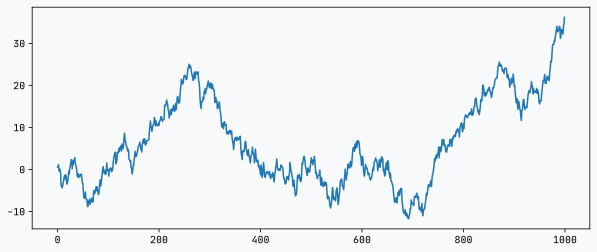

In [6]:
fig, ax = plt.subplots()

ax.plot(np.random.randn(1000).cumsum())
plt.show()

## Introduction
[Back to Table of Contents](#Table-of-Contents)

This research project aims to compare the performance of an inventory control system using classical demand forecasting against a system employing bootstrapping for estimating lead-time demand distributions. Our goal is to evaluate the effectiveness of these methods in determining re-order points and order-up-to levels for inventory management.